In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import boto3
from sklearn.model_selection import train_test_split

import math
from collections import Counter

In [20]:
bucket = 'sagemaker-us-east-1-922945788052'
prefix = 'initial_dataset/PhiUSIIL_Phishing_URL_Dataset 2.csv'

# Construct the S3 URI
s3_uri = f's3://{bucket}/{prefix}'

# Use pandas directly
df = pd.read_csv(s3_uri)

In [21]:
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


# Drop all columns

- we will drop all columns except label and url as there is no publically available feature engineering logic,
- instead we will replicate these columns using our custom logic to ensure reliability and consistency when processing inference data so inference and training feature engineering logic match

In [22]:
# drop all columns except url and label
df_dropped = df[['URL', 'label']]

In [30]:
df_dropped.head()

,URL,label
0,https://www.southbankmosaics.com,1
1,https://www.uni-mainz.de,1
2,https://www.voicefmradio.co.uk,1
3,https://www.sfnmjournal.com,1
4,https://www.rewildingargentina.org,1


## Adding features back in with custom logic to ensure conssitency in inference and improve confidence in edge cases

- only add numerical features which can be computed in real time at inference based on url alone

In [6]:
## adding back in features with custom logic, to ensure consistency when doing inference
import math
from collections import Counter
from urllib.parse import urlparse


def compute_simple_features(url):
    parsed_url = urlparse(url)
    domain = parsed_url.hostname or ""

    # 1. URLLength (remove trailing slashes for consistency)
    url_length = len(url.rstrip('/'))

    # 2. DomainLength
    domain_length = len(domain)

    # 3. IsDomainIP (check if domain is an IP address)
    is_domain_ip = int(domain.replace('.', '').isdigit())

    # 4. NoOfSubDomain
    subdomains = domain.split('.')
    no_of_subdomain = len(subdomains) - 2 if len(subdomains) > 2 else 0

    # 5. NoOfLettersInURL
    no_of_letters = sum(1 for c in url if c.isalpha())

    # 6. LetterRatioInURL
    letter_ratio = no_of_letters / url_length if url_length > 0 else 0

    # 7. NoOfDegitsInURL
    no_of_digits = sum(c.isdigit() for c in url)

    # 8. DegitRatioInURL
    digit_ratio = no_of_digits / url_length if url_length > 0 else 0

    # 9. NoOfEqualsInURL
    no_of_equals = url.count('=')

    # 10. NoOfQMarkInURL
    no_of_qmark = url.count('?')

    # 11. NoOfAmpersandInURL
    no_of_ampersand = url.count('&')

    # 12. NoOfOtherSpecialCharsInURL (excluding =, ?, &)
    other_specials = sum(
        1 for c in url if not c.isalnum() and c not in ['=', '?', '&']
    )

    # 13. SpacialCharRatioInURL
    special_char_ratio = other_specials / url_length if url_length > 0 else 0

    # 14. IsHTTPS
    is_https = 1 if parsed_url.scheme.lower() == 'https' else 0

    # 15. CharContinuationRate (repeated adjacent characters)
    repeated_chars = sum(1 for i in range(1, len(url)) if url[i] == url[i - 1])
    char_continuation_rate = repeated_chars / (len(url) - 1) if len(url) > 1 else 0

    # Return as dictionary
    return {
        'URL': url,
        'URLLength': url_length,
        'DomainLength': domain_length,
        'IsDomainIP': is_domain_ip,
        'NoOfSubDomain': no_of_subdomain,
        'NoOfLettersInURL': no_of_letters,
        'LetterRatioInURL': round(letter_ratio, 3),
        'NoOfDegitsInURL': no_of_digits,
        'DegitRatioInURL': round(digit_ratio, 3),
        'NoOfEqualsInURL': no_of_equals,
        'NoOfQMarkInURL': no_of_qmark,
        'NoOfAmpersandInURL': no_of_ampersand,
        'NoOfOtherSpecialCharsInURL': other_specials,
        'SpacialCharRatioInURL': round(special_char_ratio, 3),
        'IsHTTPS': is_https,
        'CharContinuationRate': round(char_continuation_rate, 6)
    }


In [32]:
# Assuming df has a 'URL' column
# Apply the function to each URL and expand the resulting dictionaries into columns
features_df = df_dropped['URL'].apply(compute_simple_features).apply(pd.Series)

In [33]:
df_processed = pd.concat([df[['label']], features_df], axis=1)

In [34]:
df_processed.head()

,label,URL,URLLength,DomainLength,IsDomainIP,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,CharContinuationRate
0,1,https://www.southbankmosaics.com,32,24,0,1,27,0.844,0,0.0,0,0,0,5,0.156,1,0.129032
1,1,https://www.uni-mainz.de,24,16,0,1,18,0.750,0,0.0,0,0,0,6,0.250,1,0.173913
2,1,https://www.voicefmradio.co.uk,30,22,0,2,24,0.800,0,0.0,0,0,0,6,0.200,1,0.137931
3,1,https://www.sfnmjournal.com,27,19,0,1,22,0.815,0,0.0,0,0,0,5,0.185,1,0.153846
4,1,https://www.rewildingargentina.org,34,26,0,1,29,0.853,0,0.0,0,0,0,5,0.147,1,0.121212


### Check Class Balance
- the target variable is the label, it is `0` for `phishing` and `1` for `legitmate`

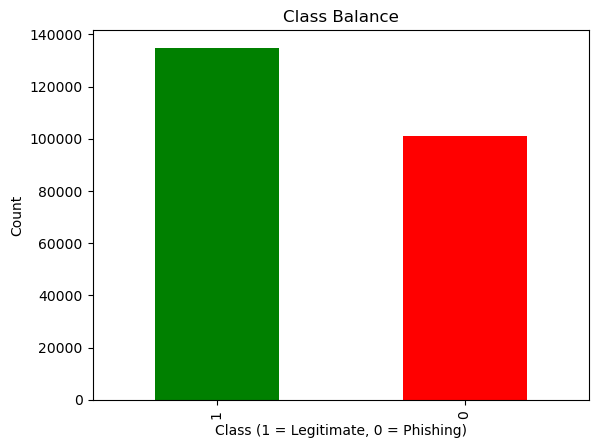

label
1    134850
0    100945
Name: count, dtype: int64
label
1    57.189508
0    42.810492
Name: proportion, dtype: float64


In [35]:
# Plot the class balance
df_processed['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Balance')
plt.xlabel('Class (1 = Legitimate, 0 = Phishing)')
plt.ylabel('Count')
plt.show()

# Print label counts
print(df_processed['label'].value_counts())

# Print class balance percentage
print(df_processed['label'].value_counts(normalize=True) * 100)

- this shows the dataset is reasonably balanced, with a slight majority of legitimate URL's, the minority class is above 40% so no data imbalance treatment is needed
- check for missing values

In [36]:
print(df_processed.isnull().sum())

label                         0
URL                           0
URLLength                     0
DomainLength                  0
IsDomainIP                    0
NoOfSubDomain                 0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
CharContinuationRate          0
dtype: int64


## Add entropy

- creating this feature, intuitively it seems that a more random url (higher entropy) would more likely be phishing

In [37]:
def calculate_entropy(url):
    counter = Counter(url)
    length = len(url)
    entropy = -sum((count / length) * math.log2(count / length)
                    for count in counter.values() if count > 0)
    return entropy

In [38]:
df_processed['URLEntropy'] = df_processed['URL'].apply(calculate_entropy)

In [39]:
df_processed.head()

,label,URL,URLLength,DomainLength,IsDomainIP,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,CharContinuationRate,URLEntropy
0,1,https://www.southbankmosaics.com,32,24,0,1,27,0.844,0,0.0,0,0,0,5,0.156,1,0.129032,3.929229
1,1,https://www.uni-mainz.de,24,16,0,1,18,0.750,0,0.0,0,0,0,6,0.250,1,0.173913,3.970176
2,1,https://www.voicefmradio.co.uk,30,22,0,2,24,0.800,0,0.0,0,0,0,6,0.200,1,0.137931,4.164735
3,1,https://www.sfnmjournal.com,27,19,0,1,22,0.815,0,0.0,0,0,0,5,0.185,1,0.153846,4.060262
4,1,https://www.rewildingargentina.org,34,26,0,1,29,0.853,0,0.0,0,0,0,5,0.147,1,0.121212,3.917626


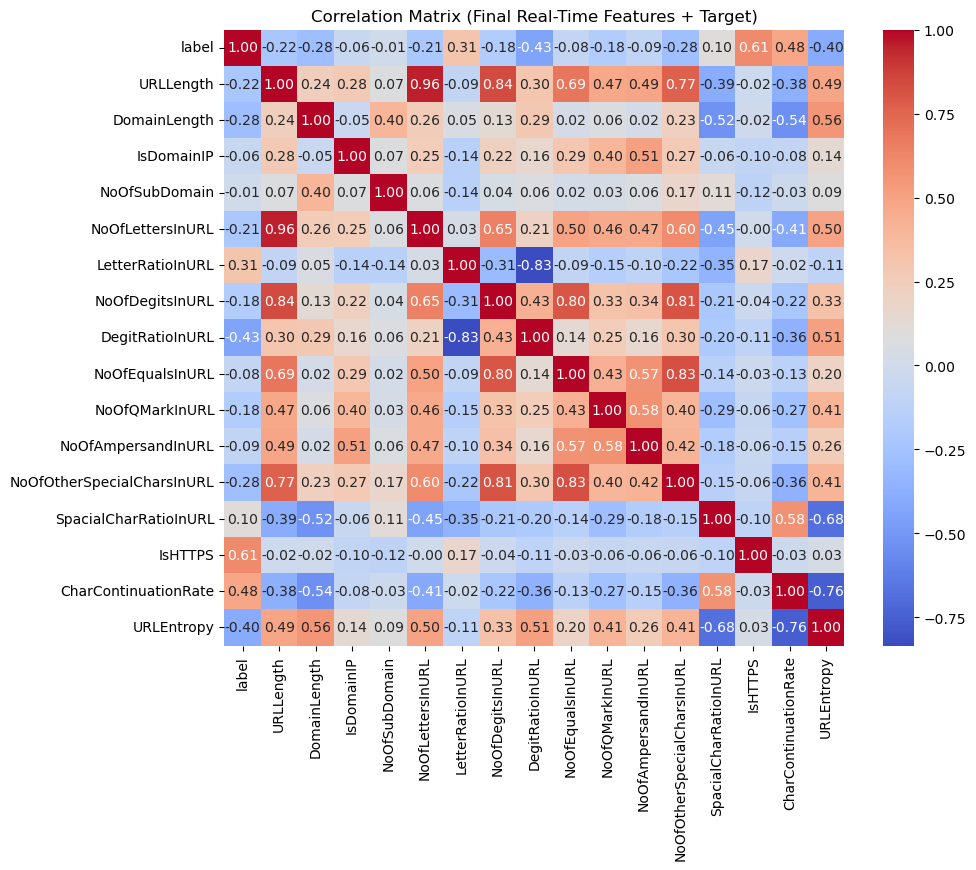

In [40]:
# Create correlation matrix for these features
corr_matrix_simple = df_processed.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_simple, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Final Real-Time Features + Target)')
plt.show()

- To avoid collinearity, we will drop features which have a correlation with each other of >0.8 these are also because count and ratio columns are avaialble so its duplication of data. This can also reduce multicolinearity.
- we will drop the following:
  -`NoOfLettersInURL`
  `NoOfDegitsInURL`
  `NoOfOtherSpecialCharsInURL`
  `DegitRatioinURL`

  some are also highly correlated, but these will be kept due to domain knowledge length, digits characters etc are present in phishing links

In [41]:
df_processed = df.drop(columns=['NoOfLettersInURL','DegitRatioInURL', 'NoOfOtherSpecialCharsInURL', 'NoOfDegitsInURL'])

In [42]:
df_processed.head()

,label,URL,URLLength,DomainLength,IsDomainIP,NoOfSubDomain,LetterRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,SpacialCharRatioInURL,IsHTTPS,CharContinuationRate,URLEntropy
0,1,https://www.southbankmosaics.com,32,24,0,1,0.844,0,0,0,0.156,1,0.129032,3.929229
1,1,https://www.uni-mainz.de,24,16,0,1,0.750,0,0,0,0.250,1,0.173913,3.970176
2,1,https://www.voicefmradio.co.uk,30,22,0,2,0.800,0,0,0,0.200,1,0.137931,4.164735
3,1,https://www.sfnmjournal.com,27,19,0,1,0.815,0,0,0,0.185,1,0.153846,4.060262
4,1,https://www.rewildingargentina.org,34,26,0,1,0.853,0,0,0,0.147,1,0.121212,3.917626


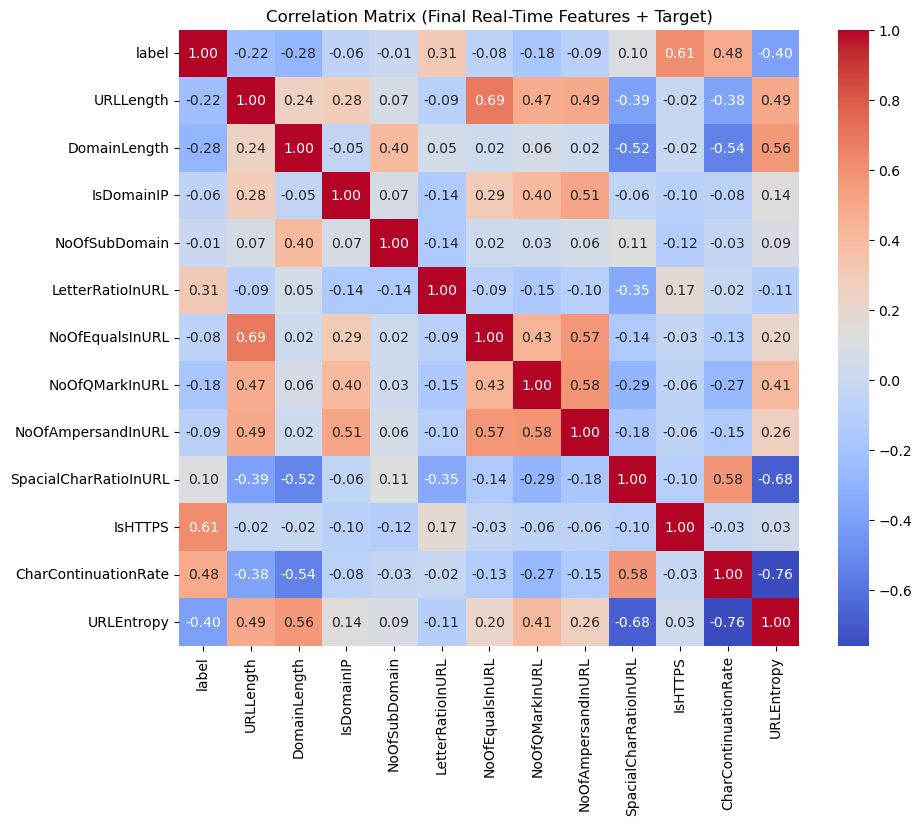

In [43]:
# replot corr matrix
corr_matrix_simple = df_processed.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_simple, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Final Real-Time Features + Target)')
plt.show()

# now our multi collinearity issue has been resolved

In [44]:
# need to drop url string
df_processed.drop(columns='URL', inplace=True)

In [45]:
# check data in correct format before saving
df_processed.head()

,label,URLLength,DomainLength,IsDomainIP,NoOfSubDomain,LetterRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,SpacialCharRatioInURL,IsHTTPS,CharContinuationRate,URLEntropy
0,1,32,24,0,1,0.844,0,0,0,0.156,1,0.129032,3.929229
1,1,24,16,0,1,0.750,0,0,0,0.250,1,0.173913,3.970176
2,1,30,22,0,2,0.800,0,0,0,0.200,1,0.137931,4.164735
3,1,27,19,0,1,0.815,0,0,0,0.185,1,0.153846,4.060262
4,1,34,26,0,1,0.853,0,0,0,0.147,1,0.121212,3.917626


In [46]:
# xg boost expects numerical features
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   label                  235795 non-null  int64  
 1   URLLength              235795 non-null  int64  
 2   DomainLength           235795 non-null  int64  
 3   IsDomainIP             235795 non-null  int64  
 4   NoOfSubDomain          235795 non-null  int64  
 5   LetterRatioInURL       235795 non-null  float64
 6   NoOfEqualsInURL        235795 non-null  int64  
 7   NoOfQMarkInURL         235795 non-null  int64  
 8   NoOfAmpersandInURL     235795 non-null  int64  
 9   SpacialCharRatioInURL  235795 non-null  float64
 10  IsHTTPS                235795 non-null  int64  
 11  CharContinuationRate   235795 non-null  float64
 12  URLEntropy             235795 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 23.4 MB


In [47]:
# Features and label
X = df_processed.drop(columns=['label'])
y = df_processed['label']

In [48]:
# First split: temp (train+val) and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Second split: train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
)


In [49]:
# Reset indices for clean concatenation
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Recombine to final dataframes with label first
train_df = pd.concat([y_train, X_train], axis=1)
val_df = pd.concat([y_val, X_val], axis=1)
test_df = pd.concat([y_test, X_test], axis=1)

In [50]:
train_df.head()

,label,URLLength,DomainLength,IsDomainIP,NoOfSubDomain,LetterRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,SpacialCharRatioInURL,IsHTTPS,CharContinuationRate,URLEntropy
0,1,23,15,0,1,0.783,0,0,0,0.217,1,0.181818,3.567040
1,1,40,32,0,1,0.875,0,0,0,0.125,1,0.128205,4.177567
2,1,27,19,0,1,0.815,0,0,0,0.185,1,0.153846,3.838040
3,1,25,17,0,1,0.800,0,0,0,0.200,1,0.166667,3.753270
4,1,30,22,0,1,0.800,0,0,0,0.200,1,0.137931,4.031402


In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165150 entries, 0 to 165149
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   label                  165150 non-null  int64  
 1   URLLength              165150 non-null  int64  
 2   DomainLength           165150 non-null  int64  
 3   IsDomainIP             165150 non-null  int64  
 4   NoOfSubDomain          165150 non-null  int64  
 5   LetterRatioInURL       165150 non-null  float64
 6   NoOfEqualsInURL        165150 non-null  int64  
 7   NoOfQMarkInURL         165150 non-null  int64  
 8   NoOfAmpersandInURL     165150 non-null  int64  
 9   SpacialCharRatioInURL  165150 non-null  float64
 10  IsHTTPS                165150 non-null  int64  
 11  CharContinuationRate   165150 non-null  float64
 12  URLEntropy             165150 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 16.4 MB


 # save final data to S3

In [53]:
# Drop completely blank rows (if any) before saving
train_df = train_df.dropna(how='all')
val_df = val_df.dropna(how='all')
test_df = test_df.dropna(how='all')

# Save to CSVs
train_df.to_csv('../data/train.csv', index=False, header=False)
val_df.to_csv('../data/validation.csv', index=False, header=False)
test_df.to_csv('../data/test.csv', index=False, header=False)

print("Saved train.csv, validation.csv, and test.csv locally (blank rows removed!).")

Saved train.csv, validation.csv, and test.csv locally (blank rows removed!).


In [54]:
# AWS S3 setup
s3 = boto3.client('s3')
bucket = 'sagemaker-us-east-1-922945788052'

# Local file paths
train_file = '../data/initial_processed_data/train.csv'
val_file = '../data/initial_processed_data/validation.csv'
test_file = '../data/initial_processed_data/test.csv'

# S3 keys
train_key = 'processed_data/train.csv'
val_key = 'processed_data/validation.csv'
test_key = 'processed_data/test.csv'

# Upload all three
s3.upload_file(train_file, bucket, train_key)
s3.upload_file(val_file, bucket, val_key)
s3.upload_file(test_file, bucket, test_key)

print(f"Uploaded {train_file} to s3://{bucket}/{train_key}")
print(f"Uploaded {val_file} to s3://{bucket}/{val_key}")
print(f"Uploaded {test_file} to s3://{bucket}/{test_key}")

Uploaded ../data/train.csv to s3://sagemaker-us-east-1-922945788052/processed_data/train.csv
Uploaded ../data/validation.csv to s3://sagemaker-us-east-1-922945788052/processed_data/validation.csv
Uploaded ../data/test.csv to s3://sagemaker-us-east-1-922945788052/processed_data/test.csv


In [55]:
df_check = pd.read_csv('s3://sagemaker-us-east-1-922945788052/processed_data/train.csv')
print(df_check.shape)
print(df_check.columns)
print(df_check.tail())

(165149, 13)
Index(['1', '23', '15', '0', '1.1', '0.783', '0.1', '0.2', '0.3', '0.217',
       '1.2', '0.181818', '3.5670402169265785'],
      dtype='object')
        1  23  15  0  1.1  0.783  0.1  0.2  0.3  0.217  1.2  0.181818  \
165144  1  27  19  0    1  0.815    0    0    0  0.185    1  0.192308   
165145  0  23  16  0    1  0.783    0    0    0  0.217    0  0.181818   
165146  0  45  34  0    2  0.778    0    0    0  0.178    1  0.066667   
165147  1  36  28  0    2  0.806    0    0    0  0.194    1  0.114286   
165148  1  27  19  0    1  0.815    0    0    0  0.185    1  0.192308   

        3.5670402169265785  
165144            3.763966  
165145            3.588354  
165146            4.207707  
165147            4.239098  
165148            3.782122  
